## Forecasting

Forecasting is a statistical process used to predict future values based on previously observed values.

### Types of Forecasting

1. **Qualitative Forecasting**: 
    - Decisions are dependent upon expert opinions.
    - There is no data available to study patterns in order to make forecasting decisions.
    - Human decision-making is involved, which introduces a chance of bias.

2. **Quantitative Forecasting**: 
    - Decisions are based on statistical and mathematical models.
    - Relies on historical data to identify patterns and make predictions.
    - Minimizes human bias by using objective data.

### Time Series Forecast

Time series forecasting is the process of analyzing time series data using statistical methods and modeling to make predictions and informed strategic decisions, It falls under Quantitative Forecasting. The data used in this process is referred to as Time Series Data.

### Rules for Accurate Forecasting

To make accurate forecasts, follow these key rules:

1. **Granularity Rule**
    - **Explanation**: The more you aggregate your data, the more accurate your forecasts will be.
    - **Reason**: Aggregated data has less variation and noise.

2. **Frequency Rule**
    - **Explanation**: Update your data frequently to include new information.
    - **Reason**: This keeps your forecasts accurate and up-to-date.

3. **Horizon Rule**
    - **Explanation**: Avoid making long-term predictions.
    - **Reason**: Short-term predictions are more accurate than long-term ones.


### Components of a Time Series Data

1. **Level**
    - **Explanation**: The baseline of any time series.
    - **Detail**: This is the base value to which other components are added to form the complete time series.

2. **Trend**
    - **Explanation**: Indicates whether the time series increases or decreases over a period.
    - **Detail**: A trend can be upward (increasing) or downward (decreasing).

3. **Seasonality**
    - **Explanation**: A repeating pattern over a specific period.
    - **Detail**: This periodic pattern is called seasonality.

4. **Cyclicity**
    - **Explanation**: A pattern that repeats aperiodically (not at fixed intervals).
    - **Detail**: Unlike seasonality, cyclic patterns do not have a fixed period.

5. **Noise**
    - **Explanation**: Random fluctuations remaining after extracting level, trend, and seasonality/cyclicity.
    - **Detail**: Noise represents the random variability in the data.


### Let's Dive Deep

In [214]:
## Imports 
import warnings 
warnings.filterwarnings('ignore')

import zipfile
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose



sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


### Constants 
DATA_FOLDER = "../data/"
ZIP_PATH = f'{DATA_FOLDER}/archive.zip'
csv_files = []
FIG_PATH = "../figures/"
ORG_DATA = pd.DataFrame()
COMMON_COMPANIES = ['AAPL', 'GOOG', 'MSFT', 'AMZN']


In [215]:
def save_figs(figname):
    plt.savefig(os.path.join(FIG_PATH, figname), format="png", dpi=300)

In [216]:
## Loading Data
with zipfile.ZipFile(file=ZIP_PATH, mode="r") as zip_file:
    zip_file.extractall(path="../data/")

print("Files unzipped successfully!")


In [217]:
csv_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')]

In [218]:
dfs = []

for file in csv_files:
    col_name = file.split(".")[0].strip()
    df = pd.read_csv(f'{DATA_FOLDER}{file}')
    # df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

    # df["Date"] = df["Date"].apply(lambda x: str(x).split(" ")[0])
    # df['Date'] = pd.to_datetime(df['Date']).dt.date
    # df.set_index('Date', inplace=True)
    # df['Adj Close'] = (df['Close'] - df['Dividends']) * df['Stock Splits']
    df = df.drop(columns=["Dividends", "Stock Splits"], axis=1)
    df["Company"] = col_name
    dfs.append(df)  

ORG_DATA = pd.concat(dfs, ignore_index=True)

data = ORG_DATA
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', utc=True)
data.set_index("Date", inplace=True)

   

#### Data Analysis

In [219]:
data.sample(10)

,Open,High,Low,Close,Volume,Company
Date,,,,,,
1995-12-01 05:00:00+00:00,2.688199,2.768444,2.688199,2.748383,44579,PEAK
2020-10-23 04:00:00+00:00,131.355027,131.657132,129.853367,131.594940,922100,TROW
2009-04-14 04:00:00+00:00,10.385390,10.778206,10.154006,10.256246,4092450,RJF
2016-07-14 04:00:00+00:00,8.517285,8.857615,8.435968,8.749191,57042900,CSX
2018-04-03 04:00:00+00:00,83.630395,84.919119,83.271944,84.774033,1413400,STT
2021-02-17 05:00:00+00:00,280.720001,283.709991,279.720001,282.579987,286600,WAT
1996-10-01 04:00:00+00:00,4.639409,4.671739,4.623244,4.671739,127600,EQR
2019-06-19 04:00:00+00:00,64.145940,64.448841,63.488209,63.912270,1250600,EMN
1990-01-03 05:00:00+00:00,6.069327,6.069327,5.968731,6.002263,209900,ES


In [220]:
# Shape
print(f'Dataset (row,col): {data.shape}')

Dataset (row,col): (4208047, 6)


In [221]:
# check column types
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4208047 entries, 2014-09-22 04:00:00+00:00 to 2023-09-21 04:00:00+00:00
Data columns (total 6 columns):
 #   Column   Dtype  
---  ------   -----  
 0   Open     float64
 1   High     float64
 2   Low      float64
 3   Close    float64
 4   Volume   int64  
 5   Company  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 224.7+ MB


In [222]:
# Missing values
print(f'Missing values in Dataset:\n{data.isnull().sum()}')

Missing values in Dataset:
Open       0
High       0
Low        0
Close      0
Volume     0
Company    0
dtype: int64


In [223]:
# Duplicates
print(f'Duplicates in Dataset: {data.duplicated().sum()}')

Duplicates in Dataset: 17154


In [224]:
pop_comps =  data[data['Company'].isin(COMMON_COMPANIES)]

### Figures 

#### Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

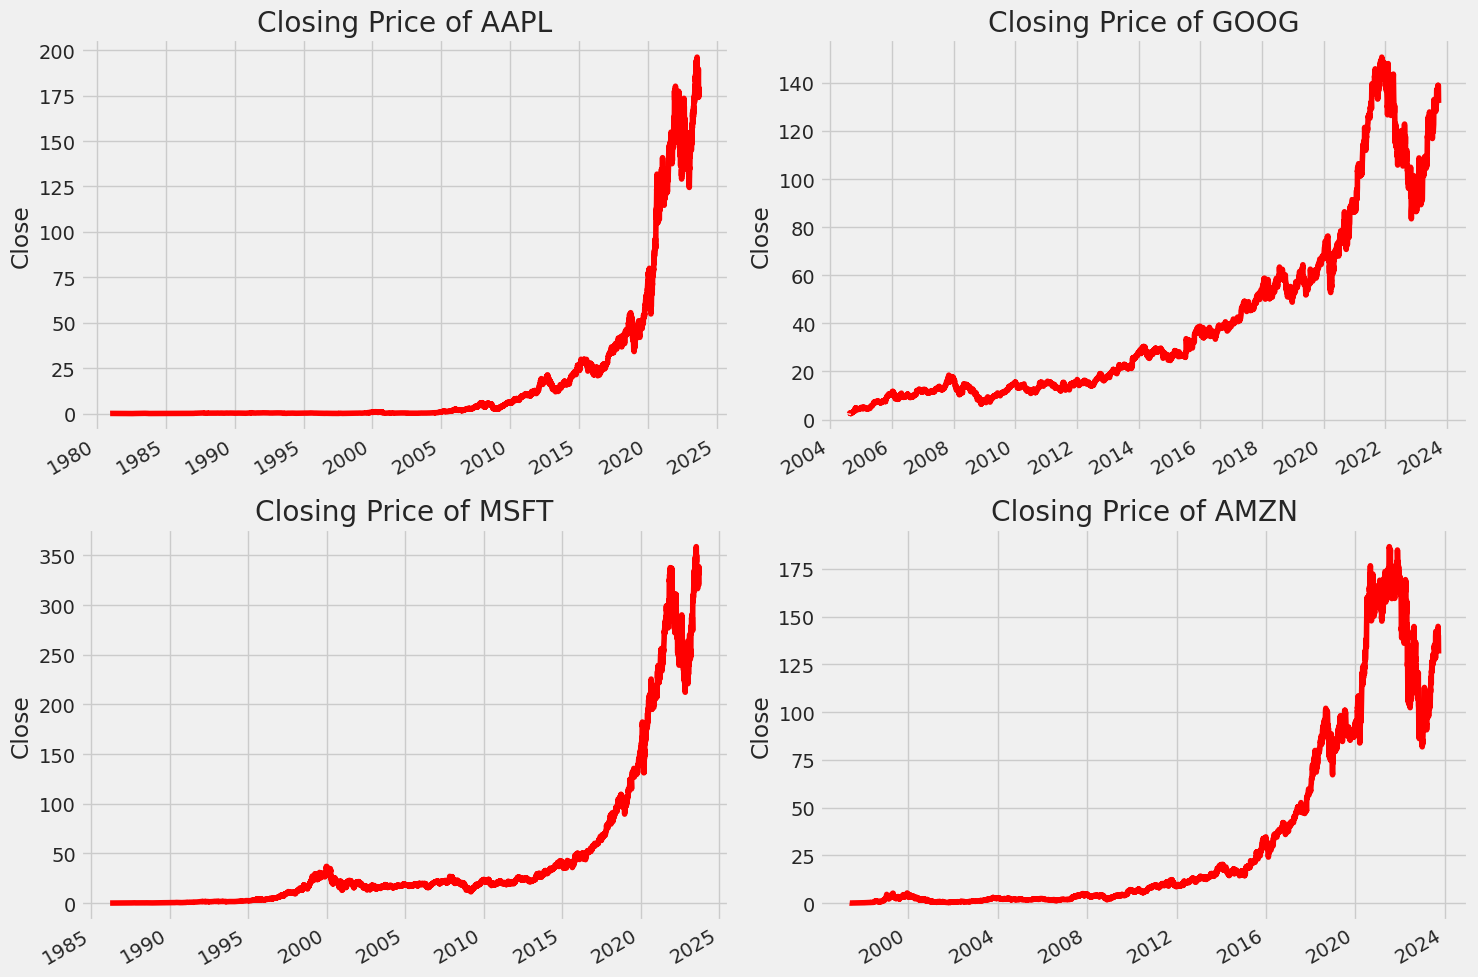

In [225]:
## Popular companies like apple
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)
for i, company in enumerate(COMMON_COMPANIES, 1):
    plt.subplot(2, 2, i)
    data[data['Company'] == company]['Close'].plot(color='red', )
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {COMMON_COMPANIES[i - 1]}")
plt.tight_layout()
save_figs("fig_1a.png")

### Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

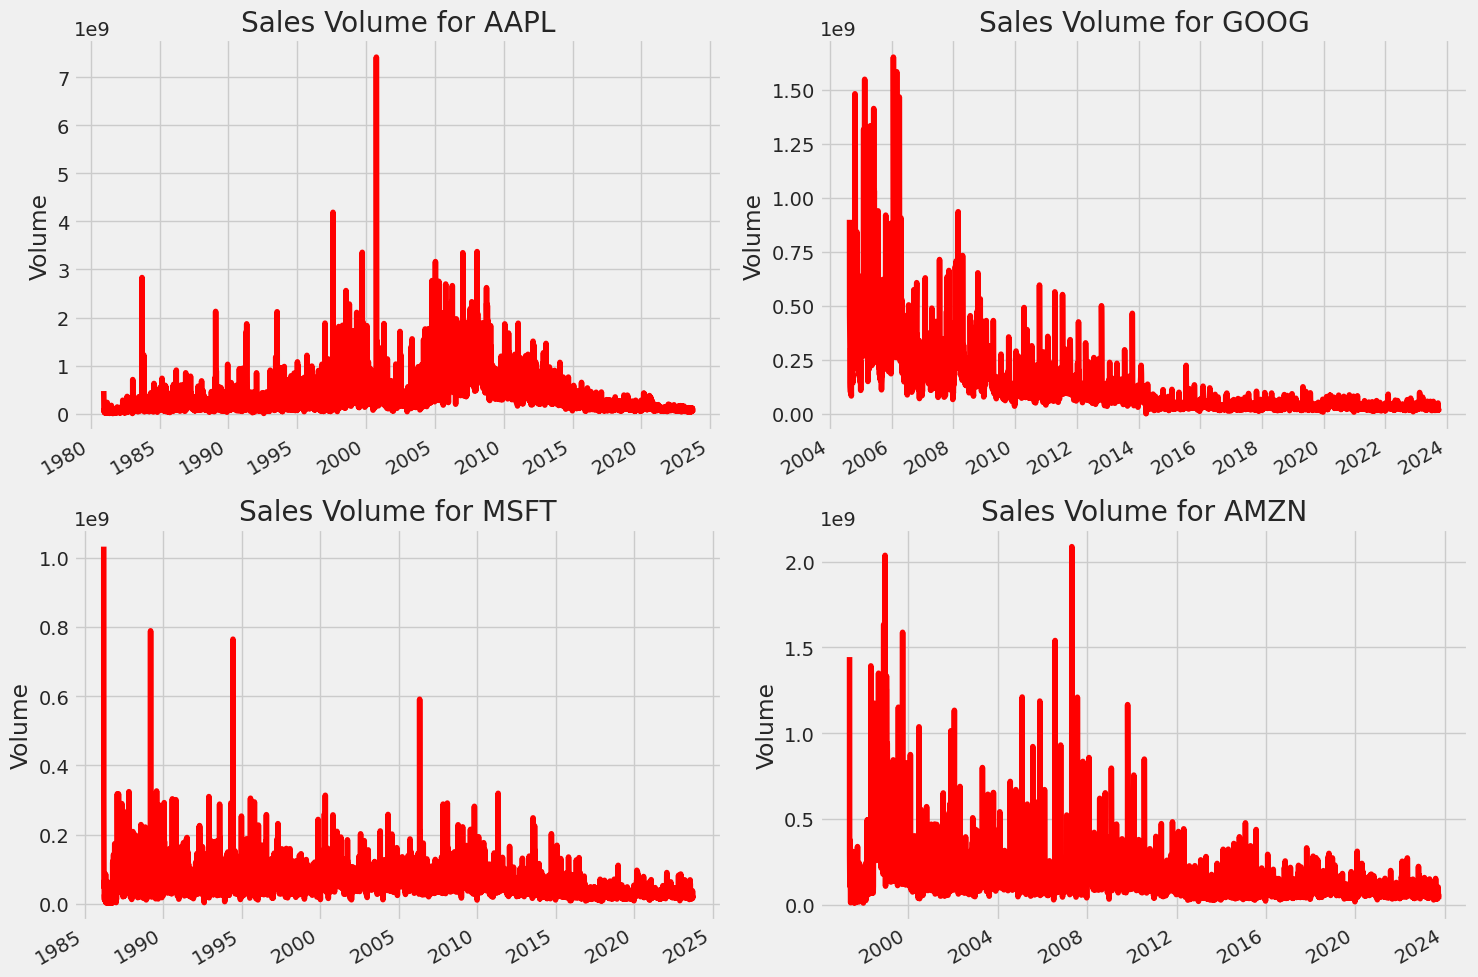

In [226]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(COMMON_COMPANIES, 1):
    plt.subplot(2, 2, i)
    data[data['Company'] == company]['Volume'].plot(color='red')
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {COMMON_COMPANIES[i - 1]}")
plt.tight_layout()
save_figs("fig_1b.png")

### What was the moving average of the various stocks?¶
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

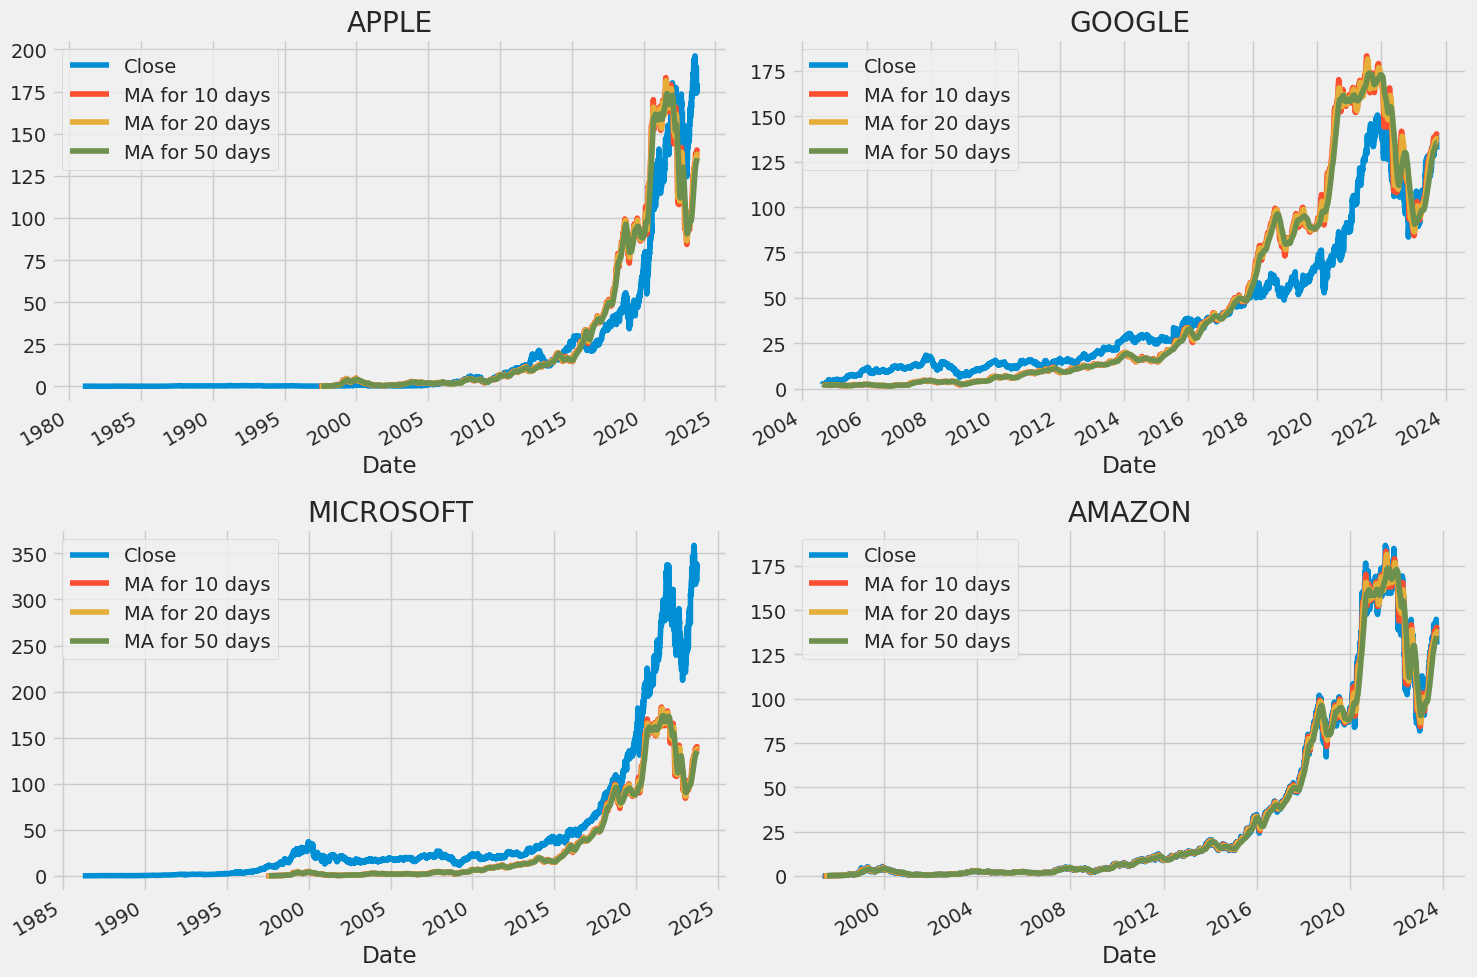

In [227]:
#moving averages plotted  
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in COMMON_COMPANIES:
        column_name = f"MA for {ma} days"
        data[column_name] = data[data['Company'] == company]["Close"].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
data[data['Company'] == "AAPL"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')
data[data['Company'] == "GOOG"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')
data[data['Company'] == "MSFT"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')
data[data['Company'] == "AMZN"][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')
fig.tight_layout()
save_figs("fig_1c.png")

We see in the graph that the best values to measure the moving average are 10 and 20 days because we still capture trends in the data without noise.

### What was the daily return of the stock on average?
Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

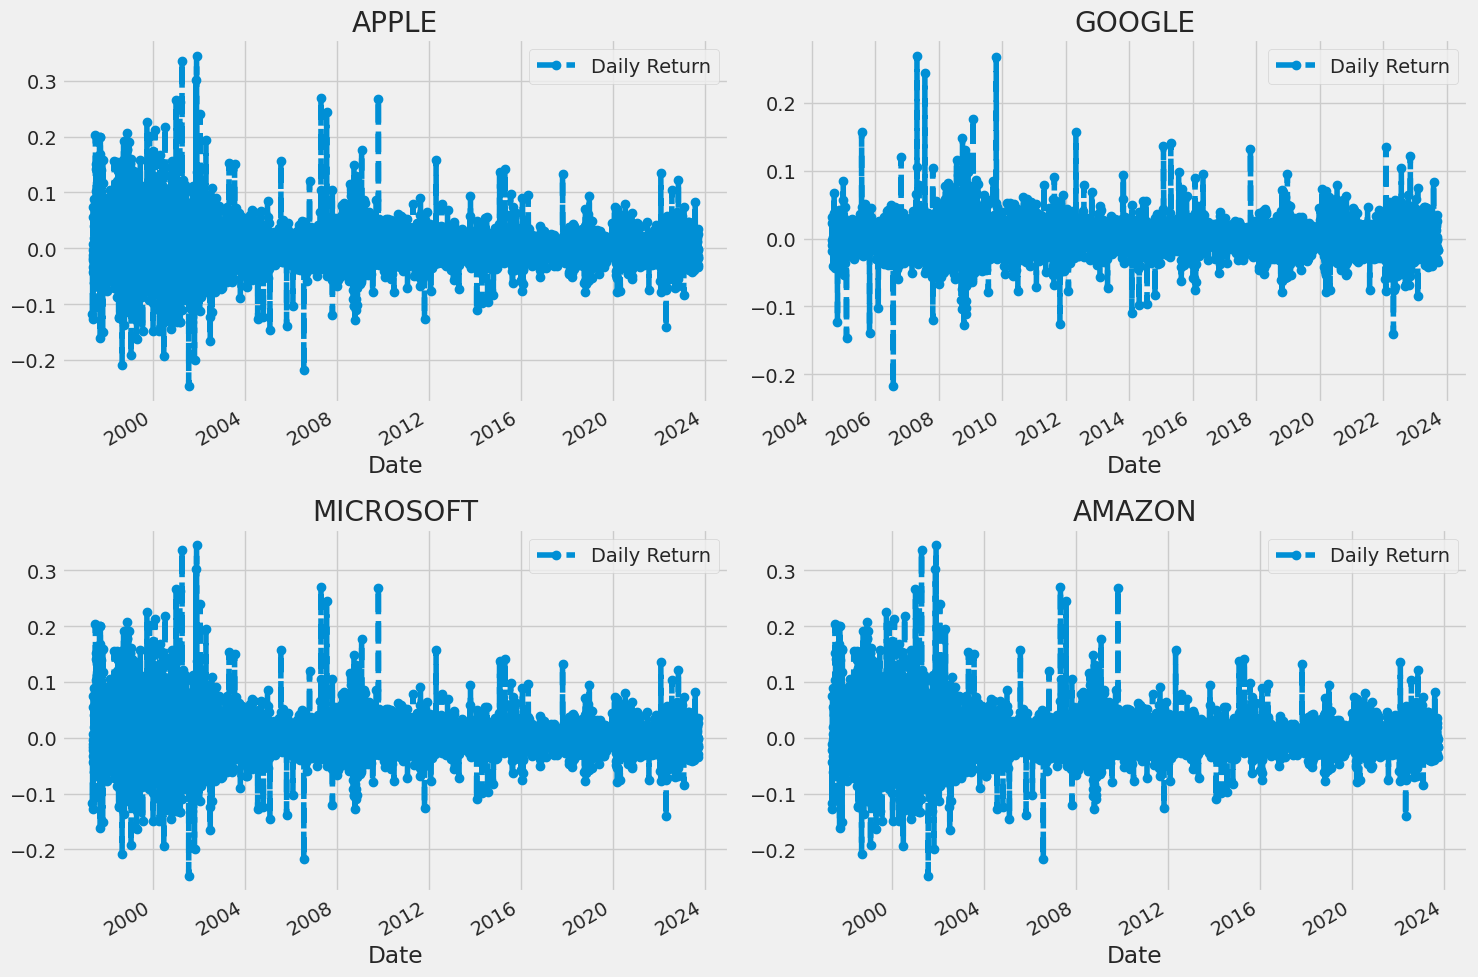

In [228]:
# We'll use pct_change to find the percent change for each day
for company in COMMON_COMPANIES:
    data['Daily Return'] = data[data['Company'] == company]['Close'].pct_change()
# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
data[data['Company'] == "AAPL"]['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')
data[data['Company'] == "GOOG"]['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')
data[data['Company'] == "MSFT"]['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')
data[data['Company'] == "AMZN"]['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')
fig.tight_layout()
save_figs("fig_1d.png")

### Time Series Analysis: Stationarity Check

Time series analysis requires stationary data. Stationarity means that the statistical properties of a series, such as the mean and variance, are constant over time. To determine if a time series is stationary, we use the Augmented Dickey-Fuller (ADF) Test.

#### Components of a Time Series

1. **Level**: The average value in the series.
2. **Trend**: The increasing or decreasing value in the series.
3. **Seasonality**: The repeating short-term cycle in the series.
4. **Noise**: The random variation in the series.

#### Augmented Dickey-Fuller (ADF) Test

The ADF test is used to determine the presence of a unit root in the series, which helps us understand if the series is stationary or not. The hypotheses for this test are:

- **Null Hypothesis (H0)**: The series has a unit root (i.e., the series is non-stationary).
- **Alternate Hypothesis (H1)**: The series does not have a unit root (i.e., the series is stationary).

#### Interpreting the Results

- If we **fail to reject** the null hypothesis, the series is **non-stationary**. This means the series might be linear or difference stationary.
- If the **mean and standard deviation** of the series are **constant** over time (i.e., flat lines), then the series is **stationary**.

In [229]:
df_close = pop_comps[pop_comps.index >= "2012-01-01"]

ADF test for AAPL:
ADF Statistic: 0.376641
p-value: 0.980600
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF test for AMZN:
ADF Statistic: -0.836046
p-value: 0.808304
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF test for GOOG:
ADF Statistic: 0.185893
p-value: 0.971459
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF test for MSFT:
ADF Statistic: 0.791777
p-value: 0.991502
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


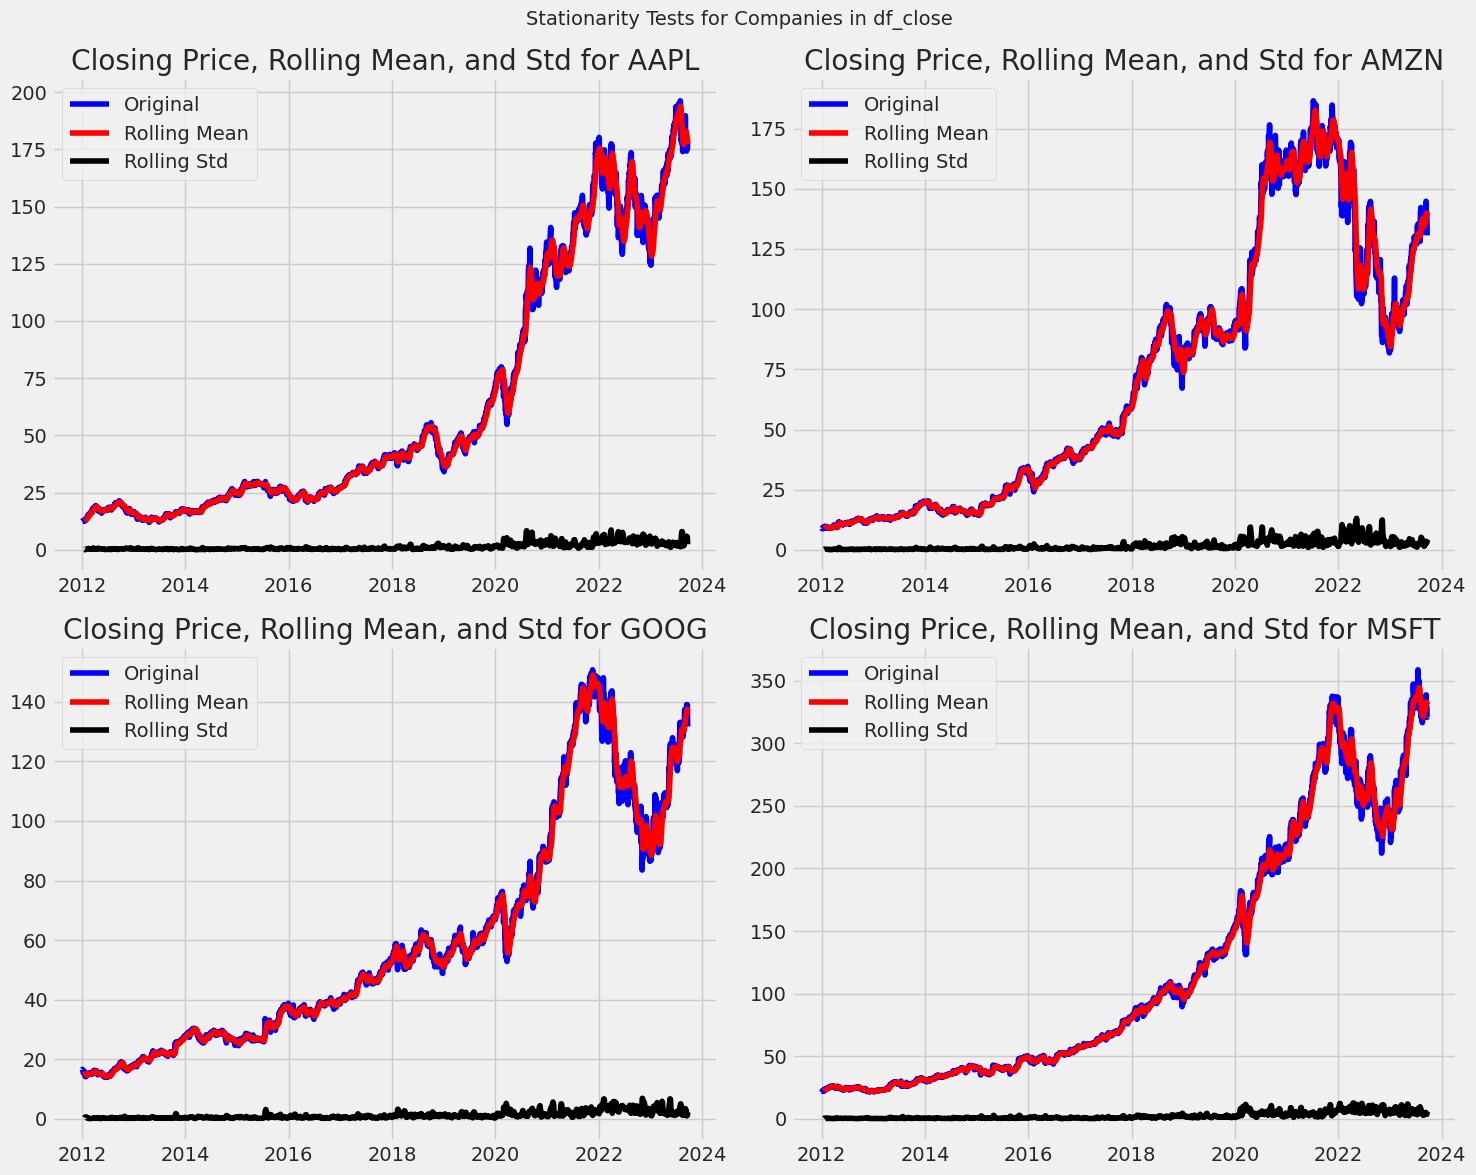

<Figure size 1000x600 with 0 Axes>

In [230]:
def test_stationarity(df):

    n_companies = len(df.groupby('Company'))
    rows, cols = (n_companies // 2) + (n_companies % 2 != 0), 2  # Grid layout for subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6))  # Adjust figure size as needed

    for company_index, (company, group) in enumerate(df.groupby('Company')):
        row, col = divmod(company_index, cols)

        # Calculate rolling mean and standard deviation
        rolmean = group['Close'].rolling(window=12).mean()
        rolstd = group['Close'].rolling(window=12).std()

        # Plot on current subplot
        axes[row, col].plot(group['Close'], color='blue', label='Original')
        axes[row, col].plot(rolmean, color='red', label='Rolling Mean')
        axes[row, col].plot(rolstd, color='black', label='Rolling Std')
        axes[row, col].legend(loc='best')
        axes[row, col].set_title(f"Closing Price, Rolling Mean, and Std for {company}")

        # ADF test
        result = adfuller(group['Close'])
        print(f"ADF test for {company}:")
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))

    # Adjust layout for all subplots if needed
    fig.suptitle('Stationarity Tests for Companies in df_close', fontsize=14)
    plt.tight_layout()
    plt.show()
    save_figs("fig_1e.png")

# Assuming you have your data in a DataFrame named 'df_close' with columns 'Company' and 'Close'
test_stationarity(df_close)


| Stock | ADF Statistic | p-value | Stationary |
|---|---|---|---|
| AAPL | 0.376641 | 0.980600 | False |
| AMZN | -0.836046 | 0.808304 | False |
| GOOG | 0.185893 | 0.971459 | False |
| MSFT | 0.791777 | 0.991502 | False |


In [231]:
df_close

,Open,High,Low,Close,Volume,Company
Date,,,,,,
2012-01-03 05:00:00+00:00,21.145995,21.472543,21.018561,21.321217,64731500,MSFT
2012-01-04 05:00:00+00:00,21.361033,21.878731,21.329175,21.822979,80516100,MSFT
2012-01-05 05:00:00+00:00,21.807061,22.085822,21.735381,22.046000,56081400,MSFT
2012-01-06 05:00:00+00:00,21.926523,22.452186,21.926523,22.388470,99455500,MSFT
2012-01-09 05:00:00+00:00,22.340679,22.380502,22.077847,22.093777,59706800,MSFT
...,...,...,...,...,...,...
2023-09-15 04:00:00+00:00,142.690002,143.570007,140.089996,140.389999,102861700,AMZN
2023-09-18 04:00:00+00:00,140.479996,141.750000,139.220001,139.979996,42823500,AMZN
2023-09-19 04:00:00+00:00,138.699997,138.839996,135.559998,137.630005,61482500,AMZN


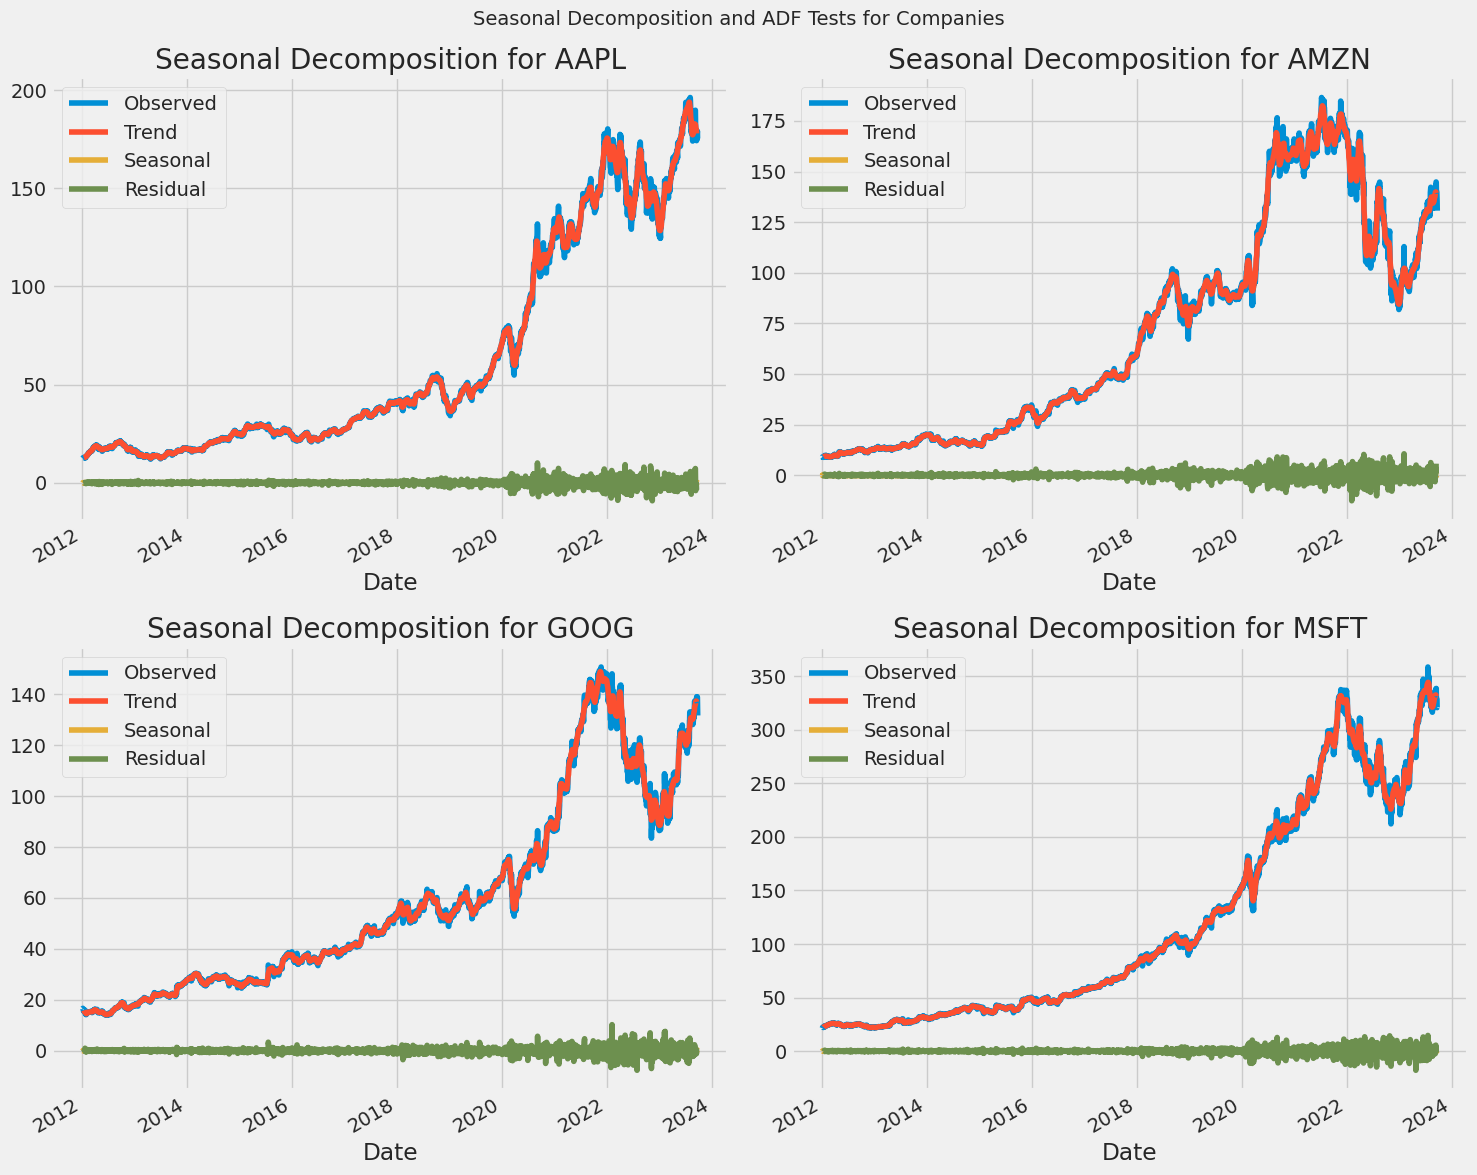

<Figure size 1000x600 with 0 Axes>

In [232]:

def apply_seasonal_decompose(df):

    n_companies = len(df.groupby('Company'))
    rows, cols = (n_companies // 2) + (n_companies % 2 != 0), 2 
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 6))  

    for company_index, (company, group) in enumerate(df.groupby('Company')):
        row, col = divmod(company_index, cols)

        # Seasonal Decomposition
        decomposition = seasonal_decompose(group['Close'], model='additive', period=12)

        # Plot components
        decomposition.observed.plot(ax=axes[row, col], label='Observed')
        decomposition.trend.plot(ax=axes[row, col], label='Trend')
        decomposition.seasonal.plot(ax=axes[row, col], label='Seasonal')
        decomposition.resid.plot(ax=axes[row, col], label='Residual')
        axes[row, col].set_title(f"Seasonal Decomposition for {company}")
        axes[row, col].legend()

    fig.suptitle('Seasonal Decomposition and ADF Tests for Companies', fontsize=14)
    plt.tight_layout()
    plt.show()
    save_figs("fig_1f.png")

    
apply_seasonal_decompose(df_close)


### Model Training

In [261]:
df = pop_comps[pop_comps["Company"] == "AAPL"]["Close"]
# df.drop(columns=["Company"])
df

Date
1980-12-12 05:00:00+00:00      0.099450
1980-12-15 05:00:00+00:00      0.094261
1980-12-16 05:00:00+00:00      0.087343
1980-12-17 05:00:00+00:00      0.089504
1980-12-18 05:00:00+00:00      0.092099
                                ...    
2023-09-15 04:00:00+00:00    175.009995
2023-09-18 04:00:00+00:00    177.970001
2023-09-19 04:00:00+00:00    179.070007
2023-09-20 04:00:00+00:00    175.490005
2023-09-21 04:00:00+00:00    175.115005
Name: Close, Length: 10784, dtype: float64

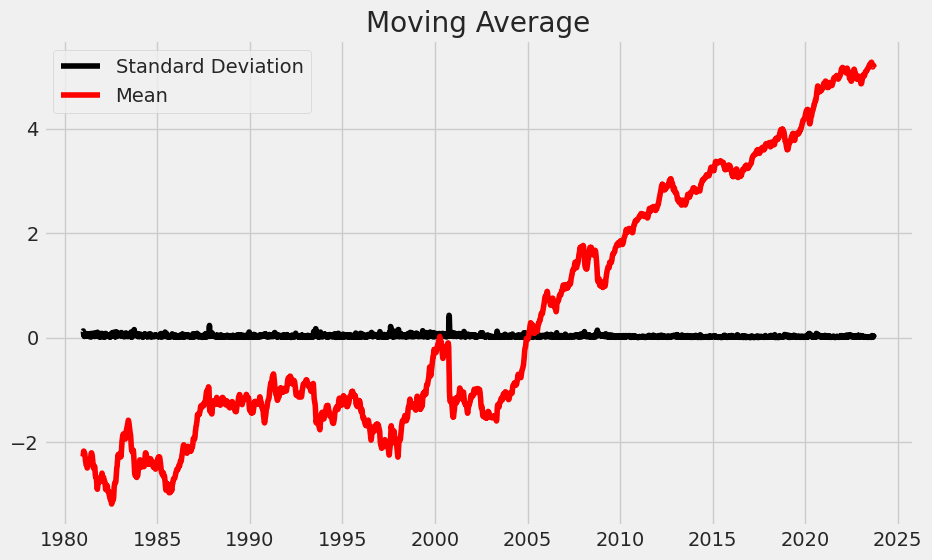

<Figure size 1000x600 with 0 Axes>

In [234]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
save_figs("fig_1g.png")


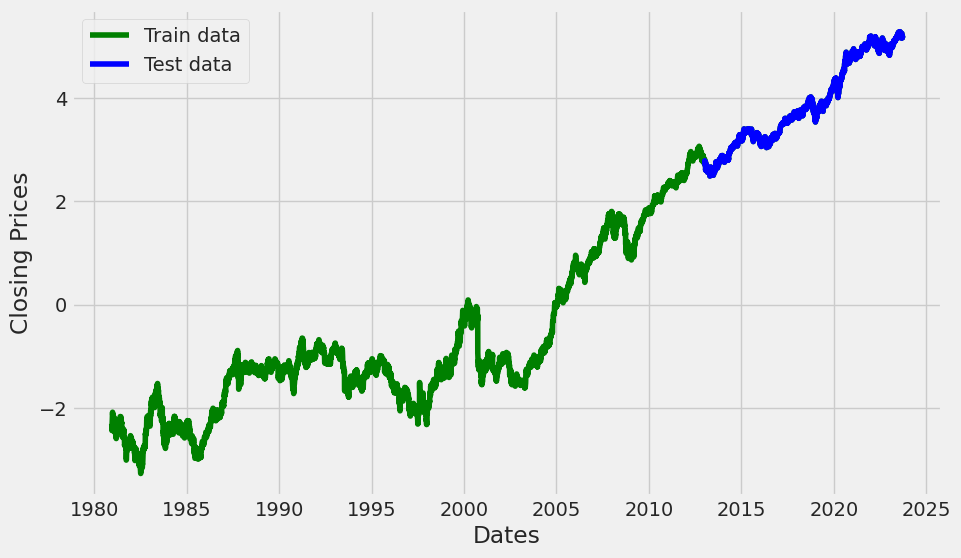

In [262]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.75)], df_log[int(len(df_log)*0.75):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
save_figs("fig_1h.png")


In [263]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import pandas as pd
import numpy as np

# Function to find the best ARIMA model
def best_arima_model(data):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    best_aic = np.inf
    best_pdq = None
    best_model = None

    for param in pdq:
        try:
            model = ARIMA(data, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_model = results
        except Exception:
            continue

    return best_model, best_pdq

# Example usage
# data = pd.Series(np.random.randn(100))  # Replace with your time series data
model, params = best_arima_model(train_data)
print(f"Best ARIMA parameters: {params}")


Best ARIMA parameters: (2, 1, 2)


In [264]:
# Build Model
model = ARIMA(train_data, order=(2,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 8085
Model:                 ARIMA(2, 1, 2)   Log Likelihood               16559.345
Date:                Thu, 08 Aug 2024   AIC                         -33108.690
Time:                        21:57:35   BIC                         -33073.702
Sample:                             0   HQIC                        -33096.720
                               - 8085                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0586      0.178      0.330      0.742      -0.290       0.407
ar.L2         -0.5316      0.140     -3.807      0.000      -0.805      -0.258
ma.L1         -0.0290      0.181     -0.161      0.8

In [266]:
test_data.shape

(2696,)

In [267]:
preds = fitted.get_forecast(2696, alpha=0.05)  # 95% conf

fc = preds.predicted_mean
# Extract standard errors
se = preds.se_mean
# Extract confidence intervals
conf = preds.conf_int()


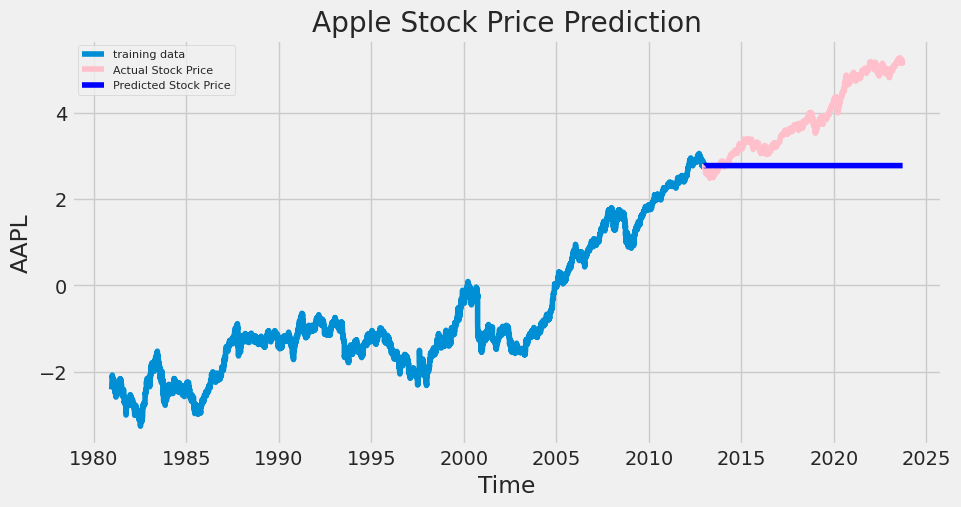

<Figure size 1000x600 with 0 Axes>

In [281]:
# Make as pandas series
fc_series = pd.Series(fc.values, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'pink', label='Actual Stock Price')
plt.plot(fc_series, color = 'blue',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL')
plt.legend(loc='upper left', fontsize=8)
plt.show()
save_figs("fig_1i.png")